# Estimating Contaminant Transport During Seasons of High Discharge in East Palistine, OH

## Introduction
At the end of Feburary, East Palistine, Ohio experienced a large chemical spill of poly-vinyl chloride. Most of the chemical was burned, causing it to vaporize into the air and be transported back into the water ways through precipitation, but a significant amount made it into the immediate groundwater and surrounding waterways, which are connected to the Ohio River. The Ohio river is an essential drinking water source for more than 5 million people, and it's contamination affects the various states that it passes through (Ohio River Valley Sanitation Commission, 2022). Because of the timing of the spill, it is relevant to consider the impact of seasonal discharge and velocity trends that occur in this region in order to estimate the amount of time the residents and surrounding communities have before mitigation and water treatment protocols need to be put in place in response.

## Research Question: Does the timing of the East Palistine spill cause more concern and less time for mitigation before it reaches the Ohio River?
In order to determine whether or not the timing of the East Palistine spill significantly affects the amount of time before it contaminates the broad-reaching Ohio River, this analysis attempts to estimate the the average monthly velocity given observed discharge and gage height measurements taken from a medium-sized river located in between the spill site and the Ohio River over the past 10 years. By finding the average monthly velocity, it will be possible to quantify the seasonal affect on the dispersion of contaminants from the chemical spill in East Palestine. In addition, probability ranges will be calculated in order to provide variability estimates based on climate and precipitation conditions in the region. My hypothesis is that the trends of snow melting and high precipitation in the spring will affect the dispersion of the chemicals, and they will spread faster during these months.

## Study Site

This analysis uses USGS daily discharge and gage height data from the Little Beaver Creek near East Liverpool, OH. East Palestine is within the bounds of this river's watershed, and the monitoring station where the data was sourced from is apart of the downstream area of the river where the spill occured. As seen in Figure 1 below, the monitoring station is around 15 miles downstream from East Palistine, OH and around 5 miles upstream of the Ohio River.
#### Figure 1
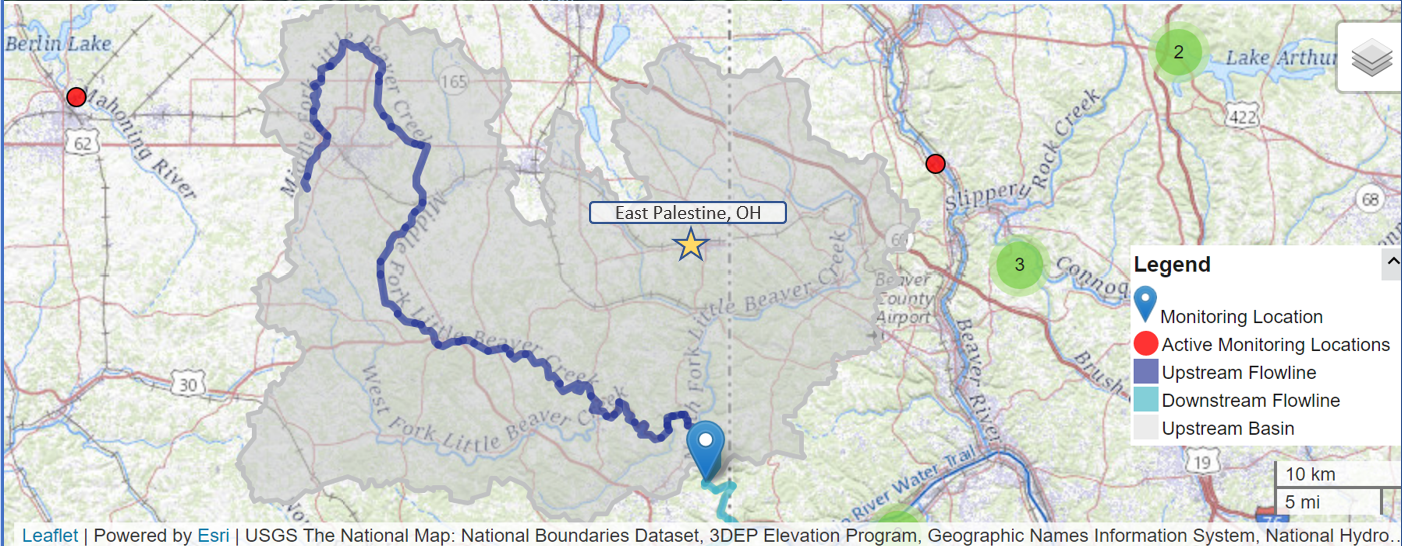

### Estimating the width of Little Beaver Creek
In order to estimate the width of the river to calculate the average cross sectional area needed for the velocity analysis, the gage site (Figure 2) was located through google maps and measured with the scale bar provided, as seen below in Figure 3. It was approximated that the width of the river was around 120 ft.
#### Figure 2
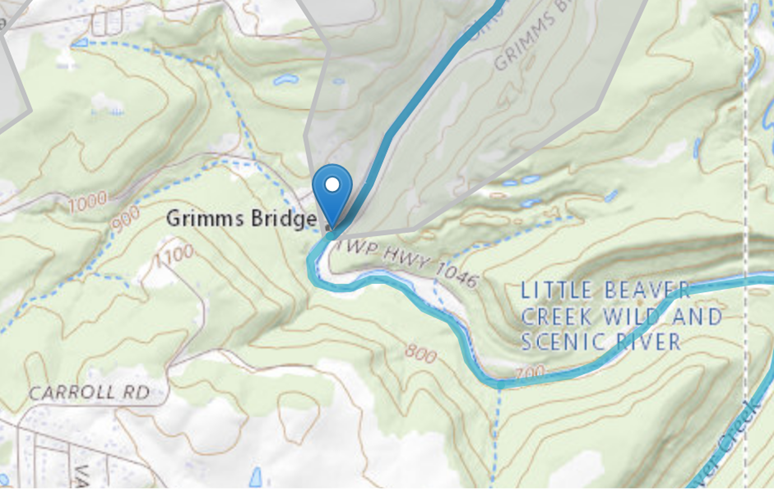
#### Figure 3
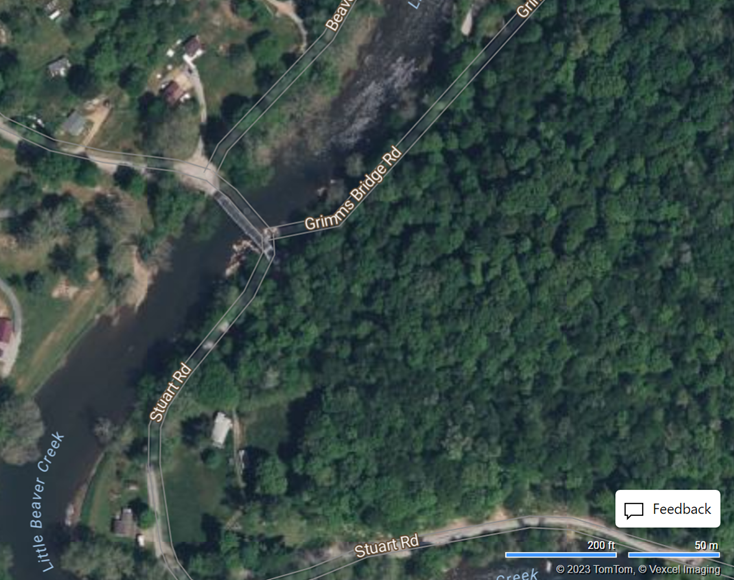

## Data Set
Daily data for both discharge and gage height at this monitoring location is availble through the USGS website, linked below, and will be used in this analysis.The data was trimmed to the past 10 years (01/01/2012 - 12/31/2022) to maintain continuous data. 

Daily discharge and gage height data from USGS from the Little Beaver Creek near East Liverpool, OH (SITE ID: 03109500): 
    https://waterdata.usgs.gov/monitoring-location/03109500/#parameterCode=00065&period=P7D
    

# Analysis

## Importing necessary packages and setting parameters

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import math 
import numpy as np
import calendar
from datetime import datetime
from scipy import stats
import os

# Parameters

# Discharge input file
dis_1 = 'lbc_dis.txt'
# Gage height input file
gage_1 = 'guage_height_lbc.txt'

# Estimated river width in ft
width = 120

# Study period start
start_date = '2012-01-01'
# Study period end
end_date = '2022-12-31'
# Study period duration in years
duration = 10

# Text for figure title
fig1_title = 'Little Beaver Creek East Liverpool, OH Discharge'

fig2_title = 'Little Beaver Creek East Liverpool, OH Velocity Curve'

fig3_title = 'Little Beaver Creek East Liverpool, OH Seasonal Velocity'

## Loading discharge data
Using a function, the daily discharge data is loaded, the unnecessary columns are removed, and the data set is trimmed to the study period.

In [2]:
def loaddata(dis_1):
    """load USGS daily discharge data using read_csv """
    
    data = pd.read_csv(dis_1,comment = '#', delimiter = '\t', header = 1, 
                       na_values = ['Ice','Bkw','SSN'])

    # Slicing the resulting data frame to remove USGS format codes in first row
    data = data.iloc[1:]     
              
    # Converting datetime column to dates, then set as index 
    data['20d'] = pd.to_datetime(data['20d'], format='%Y-%m-%d %H:%M')
    data.set_index(['20d'], inplace = True)
    data.index.names = ['Date']
    
    # Wrangling discharge column 
    data.drop(columns = {'5s','15s','10s'}, inplace = True)
    #Renaming discharge column to display units
    data.rename(columns = {'14n' : 'discharge_ft3s'}, inplace = True)
    # Trimming data to start and end dates
    data = data[start_date:end_date]
    return data

# Running the function to store it in dataframe
data = loaddata(dis_1)

### Indexing the discharge data and creating new data frame for the average monthly discharge
In order to calculate a 10 year average for each month, columns in the daily discharge dataframe ('data') are created that specify the month and year each measurement was taken. Then, a new data frame ('data_month') groups the daily measurements by year and month and takes the monthly averages separated by year. Finally, using a for-loop, the average for each month across the study period is calculated and stored in 'data_month_avg'.

In [3]:
# Adding year and month to columns in data frame
data['year'] = data.index.year
data['month'] = data.index.month

# Creating a new data frame that has the average monthly discharge for each year
#and is indexed by month
data_month = data.groupby(['year','month']).mean()    #Taking the mean
data_month = data_month.reset_index()                 #Setting month as index

# Setting parameters for loop that will take the average discharge for each 
#month in every year and creating a new data frame to store the results
month = [1,2,3,4,5,6,7,8,9,10,11,12]        #Defining the number of months
data_month_avg = pd.DataFrame(index=month)  #Indexing new data frame by number of months
data_month_avg['discharge_ft3s']=np.nan     #Filling new data frame with empty rows

# Creating for loop that will average each month's discharge measurements across the study
#period
for m in month:
    data_month_avg.loc[m,'discharge_ft3s'] = data_month.loc[data_month['month']==m,
                                                             'discharge_ft3s'].mean()

## Loading gage height data and adding the cross sectional area calculation as a column
Using a function, the daily gage height data is loaded, the unnecessary columns are removed, the data set is trimmed to the study period, and each daily measurement is divided by the estimated width to produce a corresponding cross sectional area value. 

In [4]:
def loaddata(gage_1):
    """load USGS daily gage height data using read_csv """
    
    gage_data = pd.read_csv(gage_1,comment = '#', delimiter = '\t', header = 1, 
                       na_values = ['Ice','Bkw','SSN'])

    # Slicing the resulting data frame to remove USGS format codes in first row
    gage_data = gage_data.iloc[1:]     
              
    # Converting datetime column to dates, then set as index 
    gage_data['20d'] = pd.to_datetime(gage_data['20d'], format='%Y-%m-%d %H:%M')
    gage_data.set_index(['20d'], inplace = True)
    gage_data.index.names = ['Date']
    
    # Wrangling discharge column 
    gage_data.drop(columns = {'5s','15s','10s'}, inplace = True)
    #Renameing discharge column to display units
    gage_data.rename(columns = {'14n' : 'gageheight_ft'}, inplace = True)
    # Trimming data to start and end dates
    gage_data = gage_data[start_date:end_date]
    
    # Adding column for cross sectional area by mulitplying guage height by the average width
    gage_data['area_ft2'] = (gage_data['gageheight_ft'])*width
    return gage_data

# Running the function to store it
gage_data = loaddata(gage_1)

### Indexing gage height data and creating new data frame for the average monthly cross sectional area
In order to calculate a 10 year average for each month, columns in the daily gage height dataframe ('gage_data') are created that specify the month and year each measurement was taken. Then, a new data frame ('area_month') groups the daily measurements, for both gage height and cross sectional area, by month and year and takes the monthly averages separated by year. Finally, using a for-loop, the average cross sectional area for each month across the study period is calculated and stored in 'area_month_avg'.

In [5]:
# Adding year and month to columns in gage data
gage_data['year'] = gage_data.index.year
gage_data['month'] = gage_data.index.month

# Creating a new data frame that has the average monthly cross sectional area for 
#each year and is indexed by month
area_month = gage_data.groupby(['year','month']).mean()  #Taking the mean
area_month = area_month.reset_index()                    #Setting month as index

# Setting parameters for loop that will take the average cross sectional area for 
#each month in every year and creating a new data frame to store the results
month = [1,2,3,4,5,6,7,8,9,10,11,12]         #Defining the number of months
area_month_avg = pd.DataFrame(index=month)   #Indexing new data frame by number of months
area_month_avg['area_ft2']=np.nan            #Filling new data frame with area column with empty rows

# Creating for loop that will average each month's calculated cross sectional area across 
#the study period
for m in month:
    area_month_avg.loc[m,'area_ft2'] = area_month.loc[area_month['month']==m,
                                                             'area_ft2'].mean()

C:\Users\Noah\AppData\Local\Temp\ipykernel_25256\1250012769.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  area_month = gage_data.groupby(['year','month']).mean()  #Taking the mean


## Plotting raw discharge data for intitial analysis
In order to determine if the data being used was appropriate for this study, it was relevant to acess the consistency of seasonal discharge trends across the study period. Using a simple plotting function, the raw daily discharge data was put into a time series plot. As seen in the output, there are observable seasonal trends and, apart from 2022, the maximum and minimum discharge values follow the same patterns with little variation.

<function __main__.plotdischarge(data, fig1_title)>

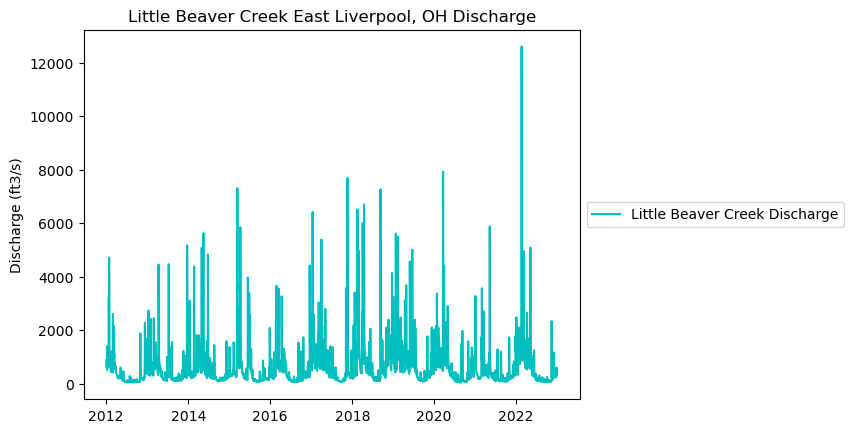

In [6]:
def plotdischarge (data,fig1_title):
    # Create plot
    fig, (ax1) = plt.subplots()
    # Plot data series
    ax1.plot(data['discharge_ft3s'], 'c-', label = 'Little Beaver Creek Discharge')
    # Add plot components
    ax1.legend(loc = 'center left', bbox_to_anchor = (1.0,0.5))
    ax1.set_ylabel('Discharge (ft3/s)')
    ax1.set_title(fig1_title)
    return plotdischarge

# Running the plotting function
plotdischarge(data, fig1_title)

## Creating a scatter plot between discharge and average cross sectional area to create a velocity curve 
In order to determine if the calculated cross sectional area would produce a reasonable estimate for velocity within the selected study period, a simple plotting curve that displayed average monthly discharge over the average monthly cross sectional area in each year was set up. As seen in the output, the resulting velocity curve shows an exponential relationship that is relatively consistent with only a few outliers. This shows correlation and supports the proceeding velocity analysis.

Text(0.5, 1.0, 'Little Beaver Creek East Liverpool, OH Velocity Curve')

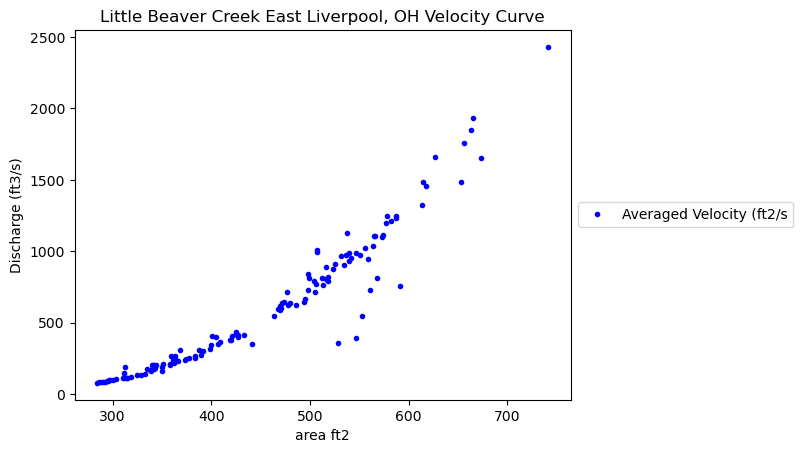

In [7]:
# Creating plot
fig, (ax1) = plt.subplots()
# Plotting data series
ax1.plot(area_month['area_ft2'],data_month['discharge_ft3s'],  #x=primary data, y=secondary data
         'b.',                               #Red marker
         label = 'Averaged Velocity (ft2/s')
# Adding plot components
ax1.legend(loc = 'center left', bbox_to_anchor = (1.0,0.5))
ax1.set_ylabel('Discharge (ft3/s)')
ax1.set_xlabel('area ft2')
ax1.set_title(fig2_title)

## Calculating quantile values for the discharge data of each month
To analyze the accuracy and relevance of performing quantile calculations to predict the maximum and minimum velocity of the river, the 95th, 75th, 50th, 25th, and 5th statistical probabilitiy ranges for the average monthly discharge values were calculated using the 'data_month' data set that has the average of every month separated by year, where the quantile calculations would be averaged over all years using a for loop. These values were stored in a separate data frame ('dfquant'), and the monthly average discharge ('data_month_avg') was added as a column wthin this dataframe.

In [8]:
# Setting up varaibles used in the function including the number of months in 
#each year and the intervals for the frequency calculations
MAXMONTH = 12
freq = [0.95, 0.75,0.5,0.25, 0.05] 

def calcquant(data,freq):
    """Calculate quantiles at specified intervals"""
    # Initializing empty data frame for results 
    dfquant = pd.DataFrame(np.full((MAXMONTH,len(freq)),np.nan),
                         columns=freq,index=np.arange(1,MAXMONTH+1))
    # Averaging monthly discharge record over all years 
    for f in freq:
        dfquant[f] = data.groupby(data['month']).quantile(f)
    return dfquant 
 
# Running the function to store it
dfquant = calcquant(data_month[['discharge_ft3s','month']],freq)
dfquant['discharge_avg_ft3s'] = data_month_avg['discharge_ft3s']

### Plot the monthly discharge quantiles for analysis
Using a plotting function, the average monthly discharge and calculated probability ranges were plotted by month. As seen in the output, the 95th and 5th probability ranges are the most reflective of the extremes, so their application in predicting the velocity during wet/dry conditions is the most relevant to the final output, especially with a data set limited in historical data like this one.

<function __main__.plotquant(data, dfquant, fig1_title)>

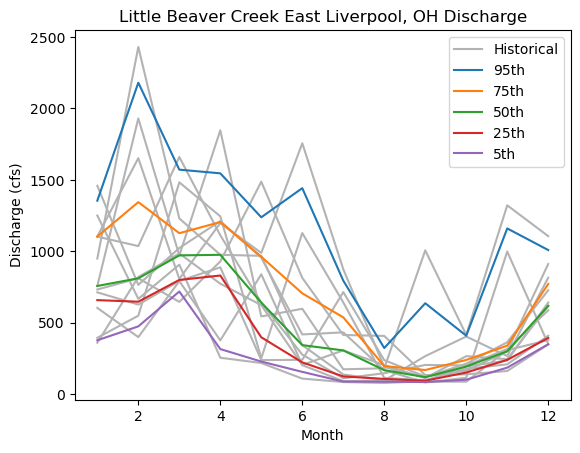

In [9]:
def plotquant(data,dfquant,fig1_title):
    """Plot time series of seasonal discharge"""
    # Create plot
    fig, ax2 = plt.subplots(nrows = 1, ncols = 1)
    #Specifying the data for the plot
    yy=data_month['year'].unique()
    # Setting Historical color to grey and only adding legend icon for the first year
    for y in yy:
        if y == yy[0]:
            ax2.plot(data_month.loc[data_month['year']==y,'month'],
                     data_month.loc[data_month['year']==y,'discharge_ft3s'],'-',
                color = '0.7',label = 'Historical')
        else:
            ax2.plot(data_month.loc[data_month['year']==y,'month'],
                 data_month.loc[data_month['year']==y,'discharge_ft3s'],'-',
            color = '0.7')
    # Plotting rest of the quantile values across every month
    for i,freq in enumerate(dfquant.columns):
        if i<5:
            ax2.plot(dfquant[freq],'-', label = f'{freq*100:.0f}th')
    # Adding plot components
    ax2.set_ylabel('Discharge (cfs)')
    ax2.set_xlabel('Month')
    ax2.legend()
    ax2.set_title(fig1_title)
    return plotquant

# Runing the plotting function
plotquant(data,dfquant,fig1_title)

## Calculate quantile values for the cross sectional area of each month
Based on the findings from the discharge quantile calculations, the same analysis was performed on the cross sectional area data ('area_month'), but only the 95th and 5th probability ranges were calculated.

In [10]:
# Setting up varaibles used in the function including the number of months in 
#each year and the intervals for the frequency calculations
MAXMONTH = 12
freq = [0.95, 0.05] 

def calcquant(data,freq):
    """Calculate quantiles at specified intervals for cross sectional area"""
    # Initializing empty data frame for results 
    area_dfquant = pd.DataFrame(np.full((MAXMONTH,len(freq)),np.nan),
                         columns=freq,index=np.arange(1,MAXMONTH+1))
    # Averaging monthly cross sectional area over all years 
    for f in freq:
        area_dfquant[f] = data.groupby(data['month']).quantile(f)
    return area_dfquant 
 
# Runing the function to store it
area_dfquant = calcquant(area_month[['area_ft2','month']],freq)

## Add the cross sectional area quantiles to the data frame where the discharge quantiles are stored in order to calculate velocity
In order to produce the final output, the area quantile calculations, as well as the average monthly cross sectional areas from 'area_month_avg', were added to the data frame storing the discharge quantile calculations (dfquant).

In [11]:
#%% Adding the cross sectional area quantiles to dfquant in order to calculate 
#velocity
dfquant['area_0.95'] = area_dfquant[0.95]
dfquant['area_0.05'] = area_dfquant[0.05]
dfquant['area_avg_ft2'] = area_month_avg['area_ft2']

## Create empty data frame for the velocity quantiles and calculate
Finally, a new data frame was crated to store the velocity calculations. By using the corresponding probaility ranges and monthly averages for discharge and cross sectional area, the 95th, 5th, and average velocity values were calculated by dividing the discharge by the cross sectional area and multiplying by 60 to convert the values from ft/s to ft/min.

In [12]:
# Creating empty data frame to store results
velocity_quant = pd.DataFrame(np.full((MAXMONTH,len(freq)),np.nan),
                              columns=freq,index=np.arange(1,MAXMONTH+1))

# Calculating velocity quantiles using corresponding discharge and area quantiles 
#and averages multiplied by 60 to convert from ft/s to ft/min
velocity_quant[0.95] = (dfquant[0.95]/dfquant['area_0.95'])*60    
velocity_quant['Average Velocity'] = (dfquant['discharge_avg_ft3s']/dfquant['area_avg_ft2'])*60
velocity_quant[0.05] = (dfquant[0.05]/dfquant['area_0.05'])*60

### Plot velocity quantiles as distance vs. time
To create the final output, the velocity probability ranges were plotted as a function of distance (x) vs. time(t). This allows for meaningful interpretation of the seasonal velocity. The maximum distance was set to 5300 ft, which is slightly over a mile, and the time was set to 300 minutes which is 5 hours total. As seen in the output below, the velocity of this river is traveling at approximately a mile an hour consistently between the months of Febuary and April, but there is high variability throughout May and June depending on the climate and precipitation trends.

Text(0.5, 0.98, 'Little Beaver Creek East Liverpool, OH Seasonal Velocity')

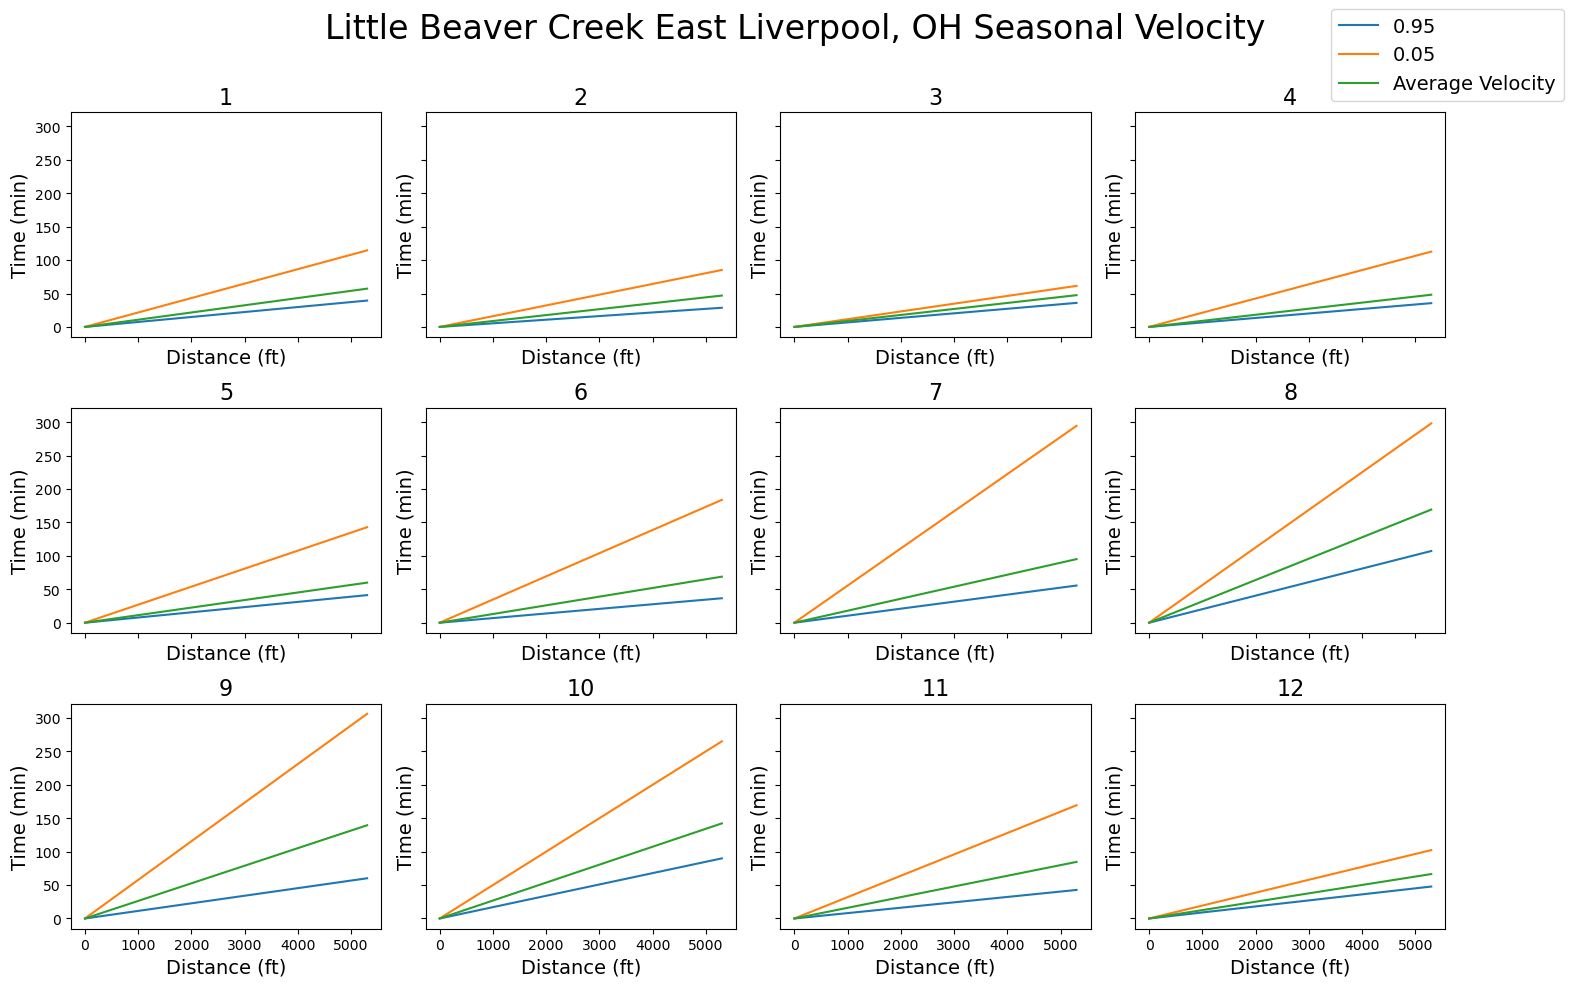

In [13]:
# Specifying distance range for (x), which is a little over a mile
x = np.arange(1,5300)
# Creating plot
fig, ax3 = plt.subplots(3, 4, sharex = True, sharey = True, figsize = (16,10))
# Setting for loop to plot each month in a differnent subplot
for m in velocity_quant.index:
    # Defining spacing for columns and rows for figure (4 columns, 3 rows)
    col = (m-1)%4
    row = math.ceil(m/4)-1
    # Adding the month number to each subplot
    ax3[row,col].set_title(m, fontsize = 16)
    # Creating another for loop to plot all three quantiles within each month subplot
    for columns in velocity_quant.columns.tolist():
        t = x/velocity_quant.loc[m,columns]
        # If statement so that legend is placed properly, and only once
        if m == 4:
            ax3[row,col].plot(x,t,               #x=distance, t=time
                   '-', label = columns)
            # Adding plot legend to upper right hand plot for proper placement
            ax3[row,col].legend(loc = 'upper left',
                                bbox_to_anchor = (0.6,1.5),
                                fontsize = 14)
            # Adding plot components
            ax3[row,col].set_ylabel('Time (min)', fontsize = 14)
            ax3[row,col].set_xlabel('Distance (ft)', fontsize = 14)
            
        else:
            ax3[row,col].plot(x,t,               #x=distance, y=time
                   '-')  
            # Adding plot components
            ax3[row,col].set_ylabel('Time (min)', fontsize = 14)
            ax3[row,col].set_xlabel('Distance (ft)',fontsize = 14)
            
# Specifying lay out and format for figure title
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle(fig3_title, fontsize = 24)

# Discussion
Overall, this study is limited due to it's reliance on a constant estimated width for the river that it analyzes. In reality, the river would be changing in both depth (gage height) and width, which would affect the final velocity measurements significantly.

In addition, the final output is limited in it's ability to predict accurate velocities for the upstream and downstream reaches of the river, as discharge and velocity vary over distance and the river is fed by other tributaries downstream. 

This study could be imporoved by adding width measurement data that could be analyzed the same way as the discharge and gage height data to create corresponding values that could be manipulated to produce more accurate results. Regardless, the final output is useful for loose estimations and observing overall seasonal trends in the region that it analyzes.

# Conclusion
Based on this analysis' findings, the severity of the spill in East Palistine, OH is likely to be increased due to it's occurance in late Feburary, as this is the time that has shown to have the highest velocity and lowest variability throughout the year at approximately 1MPH traveling speed.

While this study is limited in it's scope, it is relevant for spill management and water treatment personnel who may need to act quickly based on the time of the year that a spill occurs. Using a similar apparoach to this study could allow for nearby treatment centers to estimate the time it will take for a spilled contaminant to reach their facility based on their distance from the spill. As it can be seen in the final output, on average a contaminant would spread the fastest during late winter/early spring (February, March, April), and slowest during the late summer/early fall (July, August, September, October). The probability ranges allow for educucated estimations to be made based on the climate and precipitation trends of the current year. Based on the 95th and 5th probability ranges, if it is a wet year or a dry year the time to act will vary greatly during the summer months. 

In the case of East Palistine, OH, the region is currently predicted to experience wetter-than-average conditions (Blackwell, 2022), further exaterbating the likelihood that the contaminant will travel quickly with little time for mitigation or natural uptake before it reaches the Ohio River.

# References 
Blackwell, J. (2022). U.S. winter outlook: Warmer, drier south with ongoing La Nina. National Oceanic and Atmospheric Administration. https://www.noaa.gov/news-release/us-winter-outlook-warmer-drier-south-with-ongoing-la-nina#:~:text=Starting%20in%20December%202022%20through%20February%202023%2C%20NOAA,Valley%2C%20Great%20Lakes%2C%20northern%20Rockies%20and%20Pacific%20Northwest. 

Ohio River Valley Sanitation Commission. (2022). The Ohio River at a Glance. Ohio River Valley Sanitation Commission. https://www.orsanco.org/river-facts/ 